In [186]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

Load all buildings represented as points.

In [187]:
complete = gpd.read_parquet("/data/uscuni-ulce/boundaries_of_change/classification/")

Map ids to level 3.

In [188]:
final_clusters = pd.read_parquet("/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq")
complete["level_3"] = complete.final_without_noise.map(final_clusters[3])

Make a grid

In [189]:
bds = complete.total_bounds
bds

array([4031349.95272902, 2597498.33419905, 5378847.07173358,
       3799811.41843362])

In [190]:
x = np.arange(bds[0], bds[2], 50_000)
y = np.arange(bds[1], bds[3], 50_000)

In [191]:
xs, ys = np.meshgrid(x, y)

In [192]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(50_000, cap_style='square')

Join grid label to points

In [193]:
grid = grid.to_frame('geometry')
joined = complete.sjoin(grid, predicate='within')

Group by grid label and get counts by class.

In [194]:
counts = joined.groupby('index_right').level_3.value_counts().unstack().fillna(0)
counts = counts.div(counts.sum(axis=1), axis=0)
counts

level_3,1,2,3,4,5,6,7,8
index_right,,,,,,,,
5,0.000000,0.000000,0.816901,0.183099,0.000000,0.0,0.000000,0.000000
6,0.003155,0.000000,0.525762,0.202419,0.134595,0.0,0.000000,0.134069
7,0.008151,0.006299,0.444239,0.315672,0.094850,0.0,0.000000,0.130789
8,0.018433,0.019585,0.296083,0.552995,0.000000,0.0,0.000000,0.112903
9,0.001650,0.015829,0.202476,0.578095,0.158290,0.0,0.012903,0.030758
...,...,...,...,...,...,...,...,...
670,0.035063,0.006765,0.081218,0.347230,0.308647,0.0,0.211382,0.009695
671,0.023505,0.002865,0.161944,0.343987,0.281018,0.0,0.179413,0.007267
672,0.010641,0.002860,0.268585,0.315998,0.262257,0.0,0.138161,0.001497


Plot

In [195]:
grid_data = pd.concat([grid, counts], axis=1)

In [196]:
boundaries = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer='1994_political')

In [205]:
lt = gpd.read_file('https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/LTU/ADM0/geoBoundaries-LTU-ADM0-all.zip', layer='geoBoundaries-LTU-ADM0_simplified').to_crs(boundaries.crs)

In [198]:
cmap = ["#4069BC","#7CBAE4","#E69C63","#eec1d5","#E0665F", "#ECBF43","#b2cd32","#1F943E"]
cmap = {i: col for i, col in enumerate(cmap, 1)}

names = {
    1: "Incoherent Large-Scale \nHomogeneous Fabric",
    2: "Incoherent Large-Scale \nHeterogeneous Fabric",
    3: "Incoherent Small-Scale \nLinear Fabric",
    4: "Incoherent Small-Scale \nSparse Fabric",
    5: "Incoherent Small-Scale \nCompact Fabric",
    6: "Coherent Interconnected \nFabric",
    7: "Coherent Dense Disjoint \nFabric",
    8: "Coherent Dense Adjacent \nFabric"
    }

In [199]:
def plot_label(label, ax):
    grid_data.plot(ax=ax, color=cmap[label], alpha=grid_data[label].fillna(0) / grid_data[label].max())
    boundaries.boundary.plot(ax=ax, color='k', zorder=2, linewidth=.5)
    lt.boundary.plot(ax=ax, color='k', zorder=2, linewidth=.5)

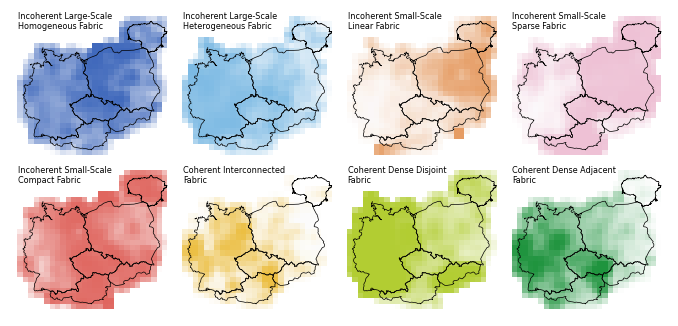

In [204]:
fig, axs = plt.subplots(2, 4, figsize=(8.5, 4), sharex=True, sharey=True)
for label, ax in enumerate(axs.flat, 1):
    plot_label(label, ax)
    ax.set_axis_off()
    ax.text(0.05, .99, names[label], fontsize='xx-small', transform=ax.transAxes, verticalalignment='top')
fig.subplots_adjust(wspace = 0.00, hspace=0.00)
fig.savefig('../data/abundance.png', bbox_inches='tight', dpi=300)

In [201]:
centres_df = pd.DataFrame(((50.07492, 14.45385), (48.19451 , 16.38641), (48.15842, 17.13337), (48.13696 , 11.58717)), columns=['y', 'x'])
centres_df = gpd.GeoSeries(gpd.points_from_xy(centres_df['x'], centres_df['y'], crs='epsg:4236')).to_crs(epsg=3035)

In [202]:
b = centres_df.buffer(10_000).iloc[0].bounds
prg = complete.cx[b[0]:b[2], b[1]:b[3]]

<Axes: >

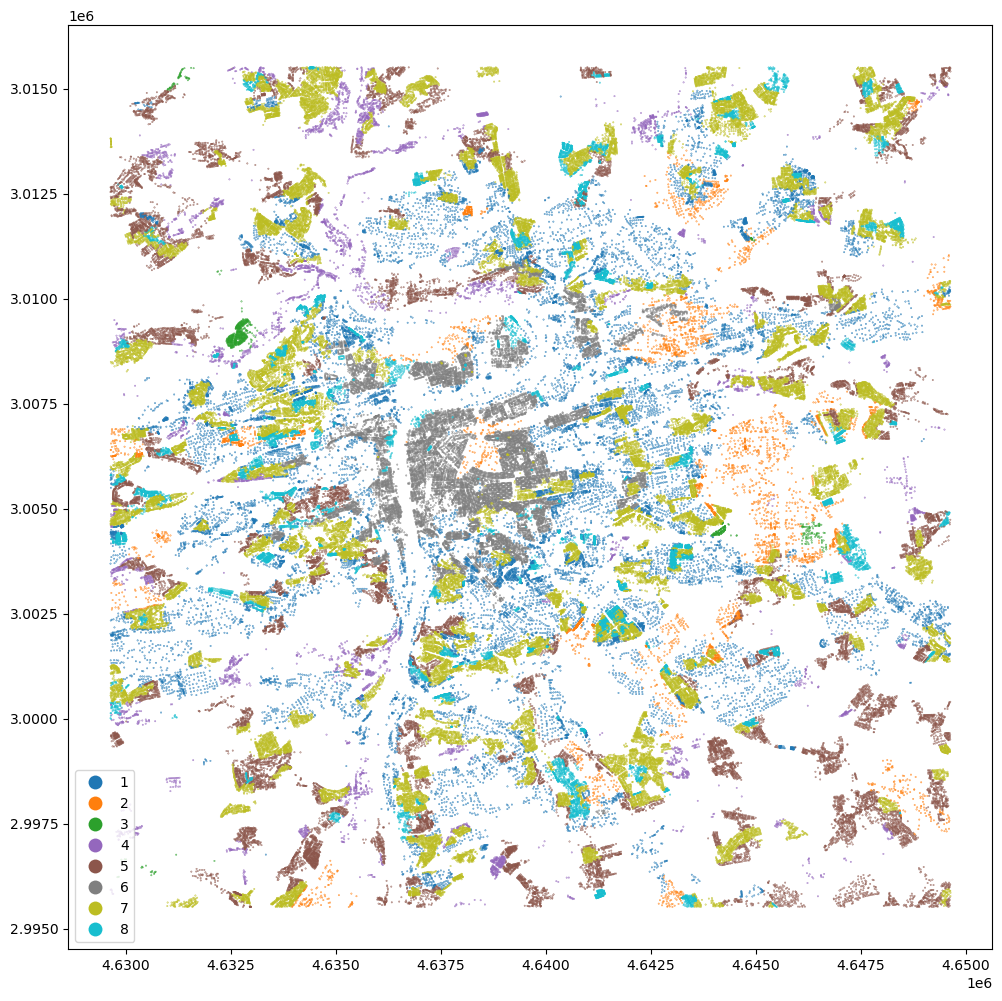

In [203]:
prg.plot('level_3', legend=True, categorical=True, figsize=(12, 12), markersize=.1)